## **02 Creating a HSC-like sample**
#### Author: **Iago Lopes (iagolops2012@gmail.com)**


In this notebook we calibrate the LSSTErrorModel by minimizing a chi-squared metric so that the resulting photometric depth closely reproduces that of the HSC Year 3 catalog. Once tuned, we apply this model to generate an “HSC-like” LSST sample. This sample will serve as the basis for our study of how uncertainties in the redshift distribution $𝑁(𝑧)$ propagate into cosmological parameter constraints in the DESC project [393]

We use the *photerr* code found in this [github repo](https://github.com/jfcrenshaw/photerr/tree/main) which came from the [DESC project 00165](https://portal.lsstdesc.org/DESCPub/app/PB/pub/show_publication?pubid=165) and is based on the Science Drivers to Reference Design and Anticipated Data Products (see: __[ArXiv:0805.2366](https://arxiv.org/abs/0805.2366)__ for details. For extended sources, the calculation is based on [van den Busch et al.(2020)](https://ui.adsabs.harvard.edu/abs/2020A%26A...642A.200V/abstract) and [Kuĳken et al. (2019)](https://www.aanda.org/articles/aa/full_html/2019/05/aa34918-18/aa34918-18.html).

Environment:

```bash
conda create --name photerr
conda activate photerr
conda install pip
conda install -c conda-forge matplotlib pandas numpy scipy astropy tqdm ipykernel
pip install photerr
python -m ipykernel install --user --name photerr
# not working...
git clone https://github.com/o-laurent/multivariate-ks-test.git
cd multivariate-ks-test && pip install .
```

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import os
from photerr import LsstErrorModel
from scipy.stats import binned_statistic_2d
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
from scipy.optimize import minimize
from mks_test import mkstest

from Plots import *

Reading and preparing data to be used.

In [2]:
hsc = pd.read_csv('hsc_y3_wide_random_100k.csv', sep=' ')
rubin = pd.read_csv('roman_rubin_random_100k_265.csv', sep=' ')

# Renaming to mag_{band}_lsst because it's easier to use with my functions
dic_rename = {
    "g_cmodel_mag":      "mag_g_lsst",
    "r_cmodel_mag":      "mag_r_lsst",
    "i_cmodel_mag":      "mag_i_lsst",
    "z_cmodel_mag":      "mag_z_lsst",
    "y_cmodel_mag":      "mag_y_lsst",
    "g_cmodel_magerr":   "mag_err_g_lsst",
    "r_cmodel_magerr":   "mag_err_r_lsst",
    "i_cmodel_magerr":   "mag_err_i_lsst",
    "z_cmodel_magerr":   "mag_err_z_lsst",
    "y_cmodel_magerr":   "mag_err_y_lsst",
}

hsc.rename(columns=dic_rename, inplace=True)

#Dust attenuation
for band in 'grizy':
    hsc[f'mag_{band}_lsst'] = hsc[f'mag_{band}_lsst'] - hsc[f'a_{band}']

In this notebook, we determine the optimal number of LSST observing years, nYrObs, and the gamma parameter that best reproduces the object density in the HSC Y3 survey across magnitude–signal-to-noise space.

The function being used within LsstErrorModel comes from eq. 5 in [Ivezic et al., 2008](https://arxiv.org/abs/0805.2366):
$$
\sigma_{\mathrm{rand}}^{2} = (0.04 - \gamma)\,x + \gamma x^{2}\;(\mathrm{mag}^{2})
$$
where $x \equiv 10^{0.4(m-m_5)}$, and:
$$
m_5 = C_m + 0.50 \,(m_{sky} - 21) + 2.5 \log_{10}\left(0.7 / \theta_{eff}\right) + 1.25 \log_{10}\left(t_{vis} / 30\right) - k_m (X - 1).
$$
The nYrObs is related to $t_{vis}$ in LsstErrorModel.

So, since $\sigma_{\mathrm{rand}}$ only depends on $\gamma$ and $x$, we can optimize only **$\gamma$** and **nYrObs**. A third parameter would be redundant.

# Chi squared 1st try

## Tunning error model

Now, we'll optimize this by computing symmetric, Poisson-weighted chi-squared between the 2D histograms of Rubin and HSC counts:
$$
\chi^2 = \Sigma \frac{(N_{rubin} - N_{hsc})^2} {(N_{rubin} + N_{hsc} + eps)}
$$
and then using a bounded scalar minimization to find the nYrObs that minimizes this discrepancy for each band.

Functions

In [3]:
def compute_counts(cat, mag_col, err_col, gridsize, maglim, snlim):
    """Builds a 2D histogram of object counts."""
    mag = cat[mag_col].values
    err_values = cat[err_col].values
    
    sn  = 1.086 / err_values
    mask = (mag > maglim[0]) & (mag < maglim[1]) & (sn > snlim[0]) & (sn < snlim[1])
    counts, _, _ = np.histogram2d(
        mag[mask], sn[mask], bins=gridsize, range=[maglim, snlim]
    )
    return counts

def loss_chi2_sym(N_1, N_2, eps=1.0):
    """Calculates the symmetric chi-squared."""
    return np.nansum((N_1 - N_2)**2 / (N_1 + N_2 + eps))

def add_error(rubin, band, nYrObs, gamma):
    # Define LSST filter names and mag column names
    mag_cols = [f"mag_{filt}_lsst" for filt in 'ugrizy']
    renameDict_mag = dict(zip('ugrizy', mag_cols))

    errModel = LsstErrorModel(
        extendedType="auto",
        ndFlag=99,
        nYrObs=nYrObs,
        gamma=gamma,
        renameDict=renameDict_mag
    )
    
    rubin_err = errModel(rubin, random_state=42)
    mag = rubin_err[f'mag_{band}_lsst']
    mag_err = rubin_err[f'mag_{band}_lsst_err']
    return mag, mag_err

def objective(params, cat, N_hsc, band, gridsize, maglim, snlim):
    gamma, nYrObs = params
    
    mag, mag_err = add_error(cat, band, nYrObs, gamma)
    cat_tmp = cat.copy()
    cat_tmp[f"mag_{band}_lsst"] = mag
    cat_tmp[f"mag_{band}_lsst_err"] = mag_err
    
    N_rubin = compute_counts(
        cat_tmp,
        mag_col=f"mag_{band}_lsst",
        err_col=f"mag_{band}_lsst_err",
        gridsize=gridsize,
        maglim=maglim,
        snlim=snlim
    )
    return loss_chi2_sym(N_rubin, N_hsc)

1st test to see our optimization surface

40it [04:08,  6.21s/it]


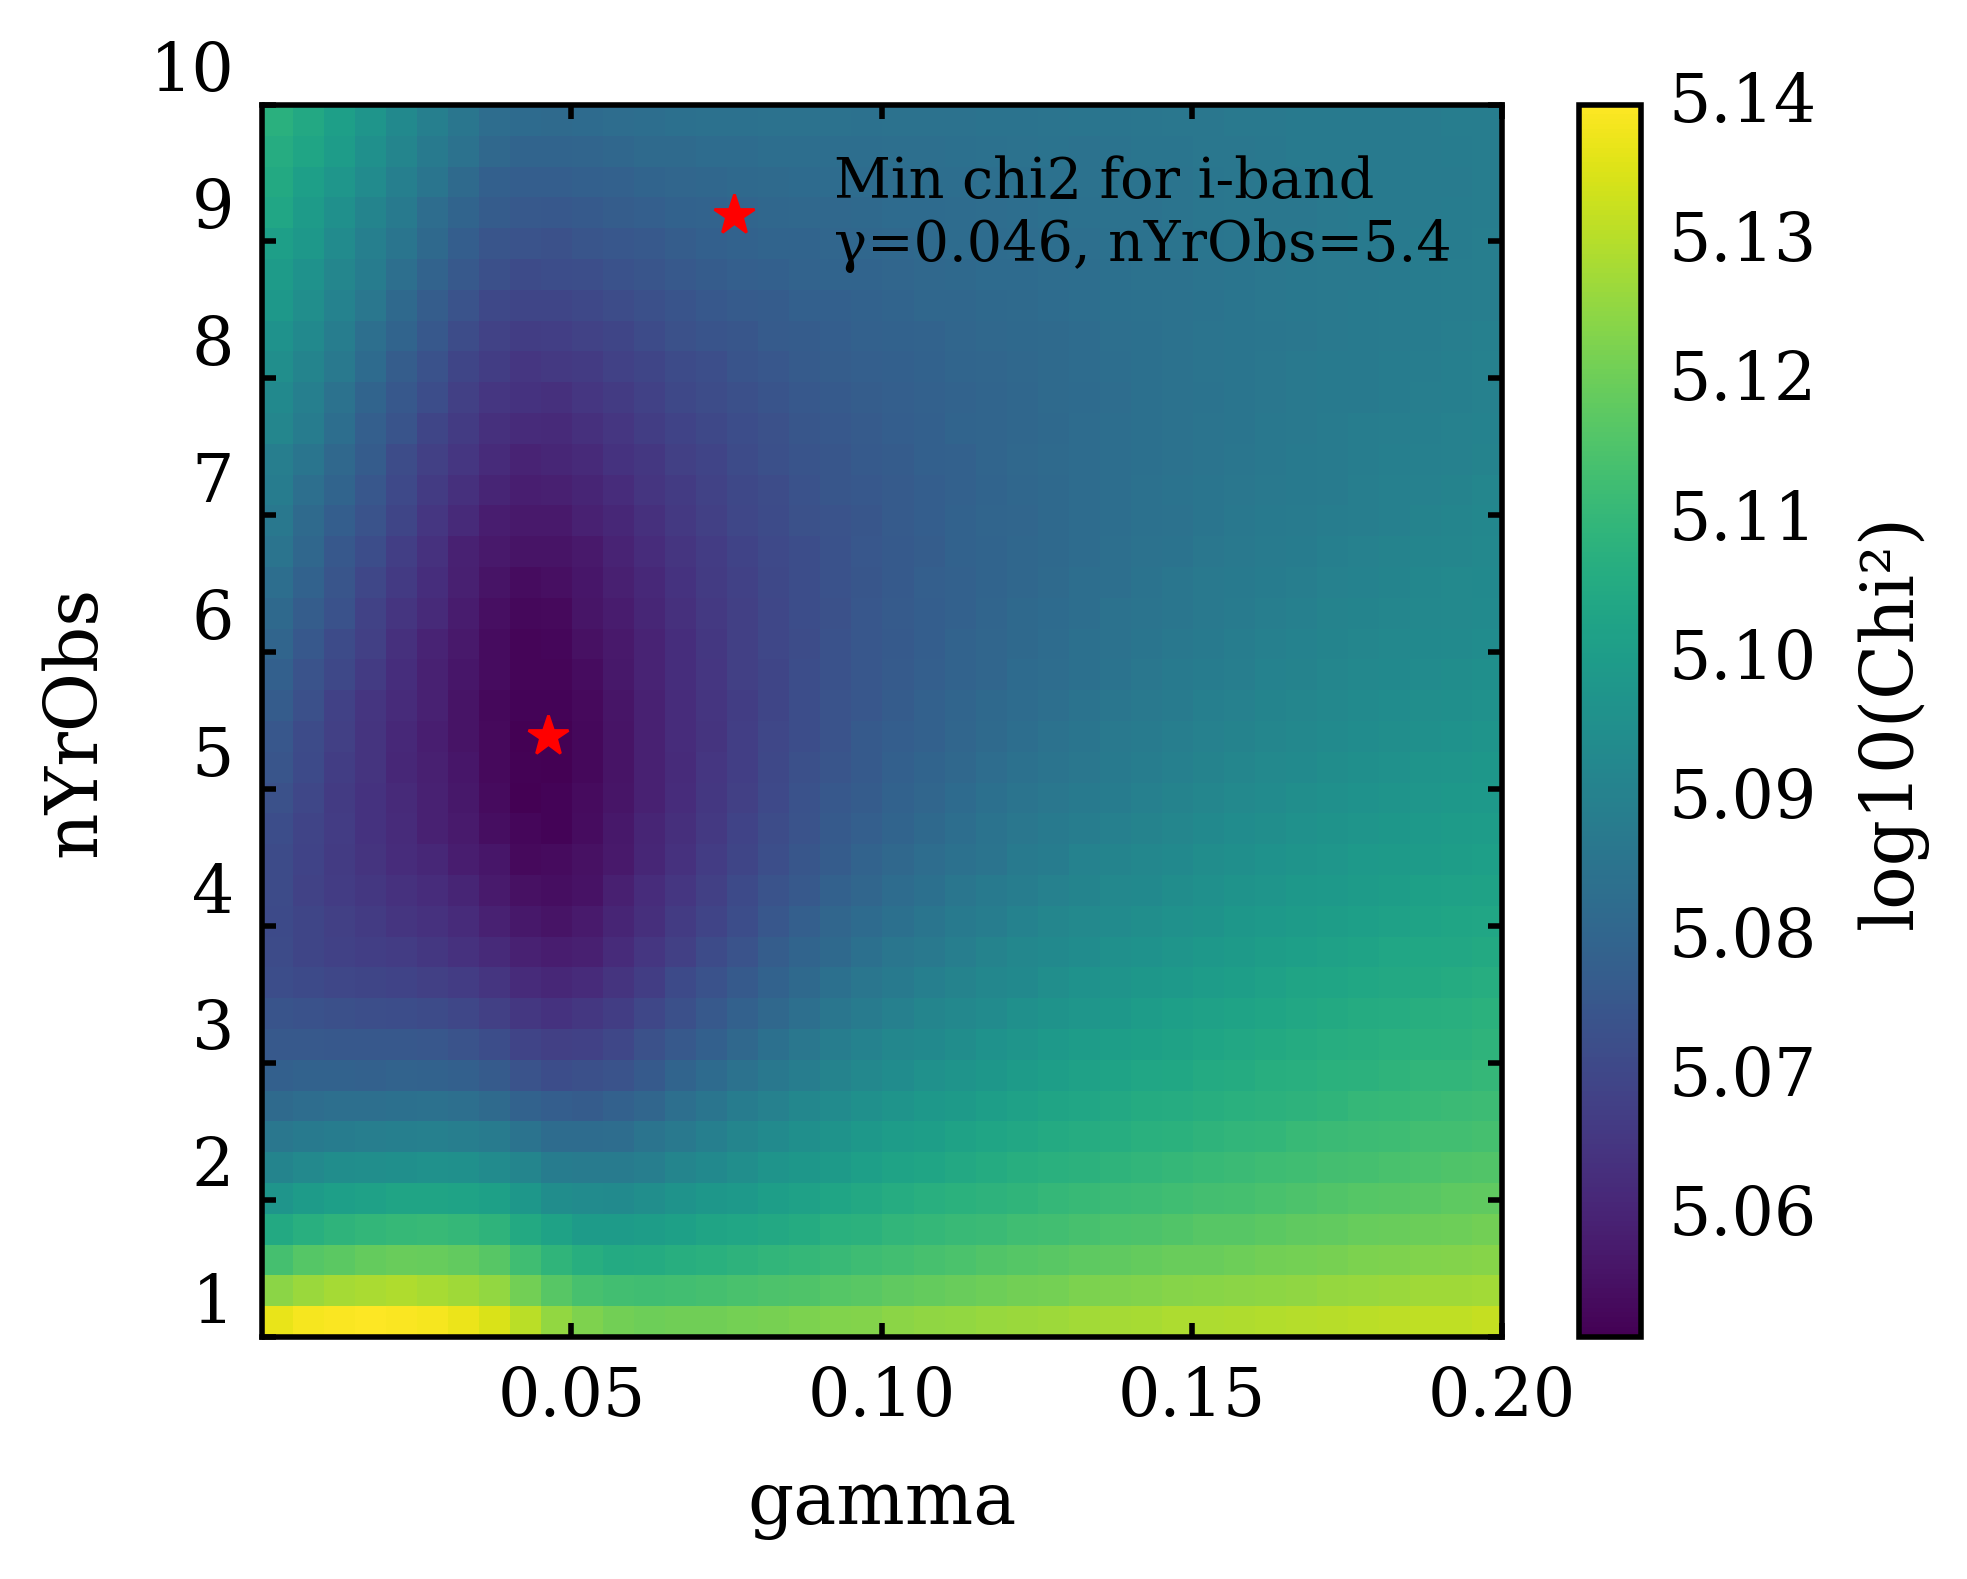

In [4]:
########## Base parameters ##########
x0 = [0.039, 5] # initial guess (gamma, nYrObs)
bounds = [(0.0001, 0.2), (1, 10)] # (gamma, nYrObs)
gridsize = 400
maglim = [18,30]
snlim = [0,100]

band_to_test = 'i'
#####################################

# Defining parameters' grid
gamma_vals = np.linspace(0.0001, 0.2, 40)  
nyrobs_vals = np.linspace(1, 10, 40)      

chi2_grid = np.zeros((len(nyrobs_vals), len(gamma_vals)))

# HSC number
Nh = compute_counts(hsc, f'mag_{band_to_test}_lsst', f'mag_err_{band_to_test}_lsst', gridsize, maglim, snlim)

# Calculating chi2 grid
for i, nyrobs in tqdm(enumerate(nyrobs_vals)):
    for j, gamma in enumerate(gamma_vals):
        params = [gamma, nyrobs]
        loss = objective(params, rubin, Nh, band_to_test, gridsize, maglim, snlim)
        chi2_grid[i, j] = loss
        

# Plotting
plt.figure(figsize=(10, 8))
img = plt.imshow(np.log10(chi2_grid), origin='lower', aspect='auto',
                 extent=[gamma_vals.min(), gamma_vals.max(), nyrobs_vals.min(), nyrobs_vals.max()])
plt.colorbar(img, label='log10(Chi²)')
plt.xlabel('gamma')
plt.ylabel('nYrObs')

# Finding the best parameters here
min_idx = np.unravel_index(np.argmin(chi2_grid), chi2_grid.shape)
best_nyrobs = nyrobs_vals[min_idx[0]]
best_gamma = gamma_vals[min_idx[1]]

plt.plot(best_gamma, best_nyrobs, 'r*', markersize=15, label=f'Min chi2 for {band_to_test}-band \nγ={best_gamma:.3f}, nYrObs={best_nyrobs:.1f}')
plt.legend()
plt.grid(False)
plt.show()

Optimizing

In [5]:
########## Base parameters ##########
x0 = [0.039, 5] # initial guess (gamma, nYrObs)
bounds = [(0.0001, 0.2), (1, 10)] # (gamma, nYrObs)
gridsize = 400
maglim = [18,30]
snlim = [0,100]
#####################################
results = {}

for band in 'grizy':
    N_hsc = compute_counts(hsc, f'mag_{band}_lsst', f'mag_err_{band}_lsst', gridsize, maglim, snlim)
    
    res = minimize(
        objective,
        x0,
        args=(rubin, N_hsc, band, gridsize, maglim, snlim),
        bounds=bounds,
        method='Nelder-Mead'
    )

    results[band] = {'gamma': res.x[0], 'nYrObs': res.x[1]}
    print(f"#### Band {band} ####")
    print("Best gamma:", res.x[0])
    print("Best nYrObs:", res.x[1])
    print("Chi²:", res.fun)
print("Degrees of freedom:",len(rubin)-2)

#### Band g ####
Best gamma: 0.044918522903544776
Best nYrObs: 4.386694063303864
Chi²: 73318.40532079188
#### Band r ####
Best gamma: 0.04413352498976364
Best nYrObs: 2.0829928379313047
Chi²: 93235.24210032893
#### Band i ####
Best gamma: 0.04342129102965484
Best nYrObs: 5.122996330093883
Chi²: 113017.08862180702
#### Band z ####
Best gamma: 0.048307139357662315
Best nYrObs: 3.849074447172711
Chi²: 98244.51123492308
#### Band y ####
Best gamma: 0.05523608022271908
Best nYrObs: 5.355915611195087
Chi²: 90275.42792933279
Degrees of freedom: 99998


## Applying ErrorModel on Roman Rubin

Now, with the best paramters for each band in hands, we'll add errors using them and create the final dataset.

In [6]:
rubin_test = pd.read_csv('test_roman_rubin_random_100k_265.csv', sep=' ')

In [7]:
gamma_list = []
nyrobs_list = []

all_mag = {}
all_magerr = {}
for band in 'grizy':
    temp_rubin = rubin_test.copy()
    
    gamma_list.append(results[band]['gamma'])
    nyrobs_list.append(results[band]['nYrObs'])
    
    mag, magerr = add_error(temp_rubin, band, results[band]['nYrObs'], results[band]['gamma'])
    all_mag[band] = mag
    all_magerr[band] = magerr

u_mag, u_magerr = add_error(rubin_test, 'u', np.mean(nyrobs_list), np.mean(gamma_list))
all_mag['u'] = u_mag
all_magerr['u'] = u_magerr

In [8]:
for band in 'ugrizy':
    rubin_test[f'mag_{band}_lsst'] = all_mag[band]
    rubin_test[f'mag_err_{band}_lsst'] = all_magerr[band]

In [9]:
for band in 'grizy':
    N_rubin = compute_counts(rubin_test, f'mag_{band}_lsst', f'mag_err_{band}_lsst', 400, [18,30], [0,100])
    N_hsc = compute_counts(hsc, f'mag_{band}_lsst', f'mag_err_{band}_lsst', 400, [18,30], [0,100])
    loss = loss_chi2_sym(N_rubin, N_hsc, eps=1.0)
    print(f'Chi2 for test sample ({band}-band):', loss)

Chi2 for test sample (g-band): 74101.75320167451
Chi2 for test sample (r-band): 94046.1895786029
Chi2 for test sample (i-band): 113564.4260417521
Chi2 for test sample (z-band): 99008.07538238971
Chi2 for test sample (y-band): 90947.19990519996


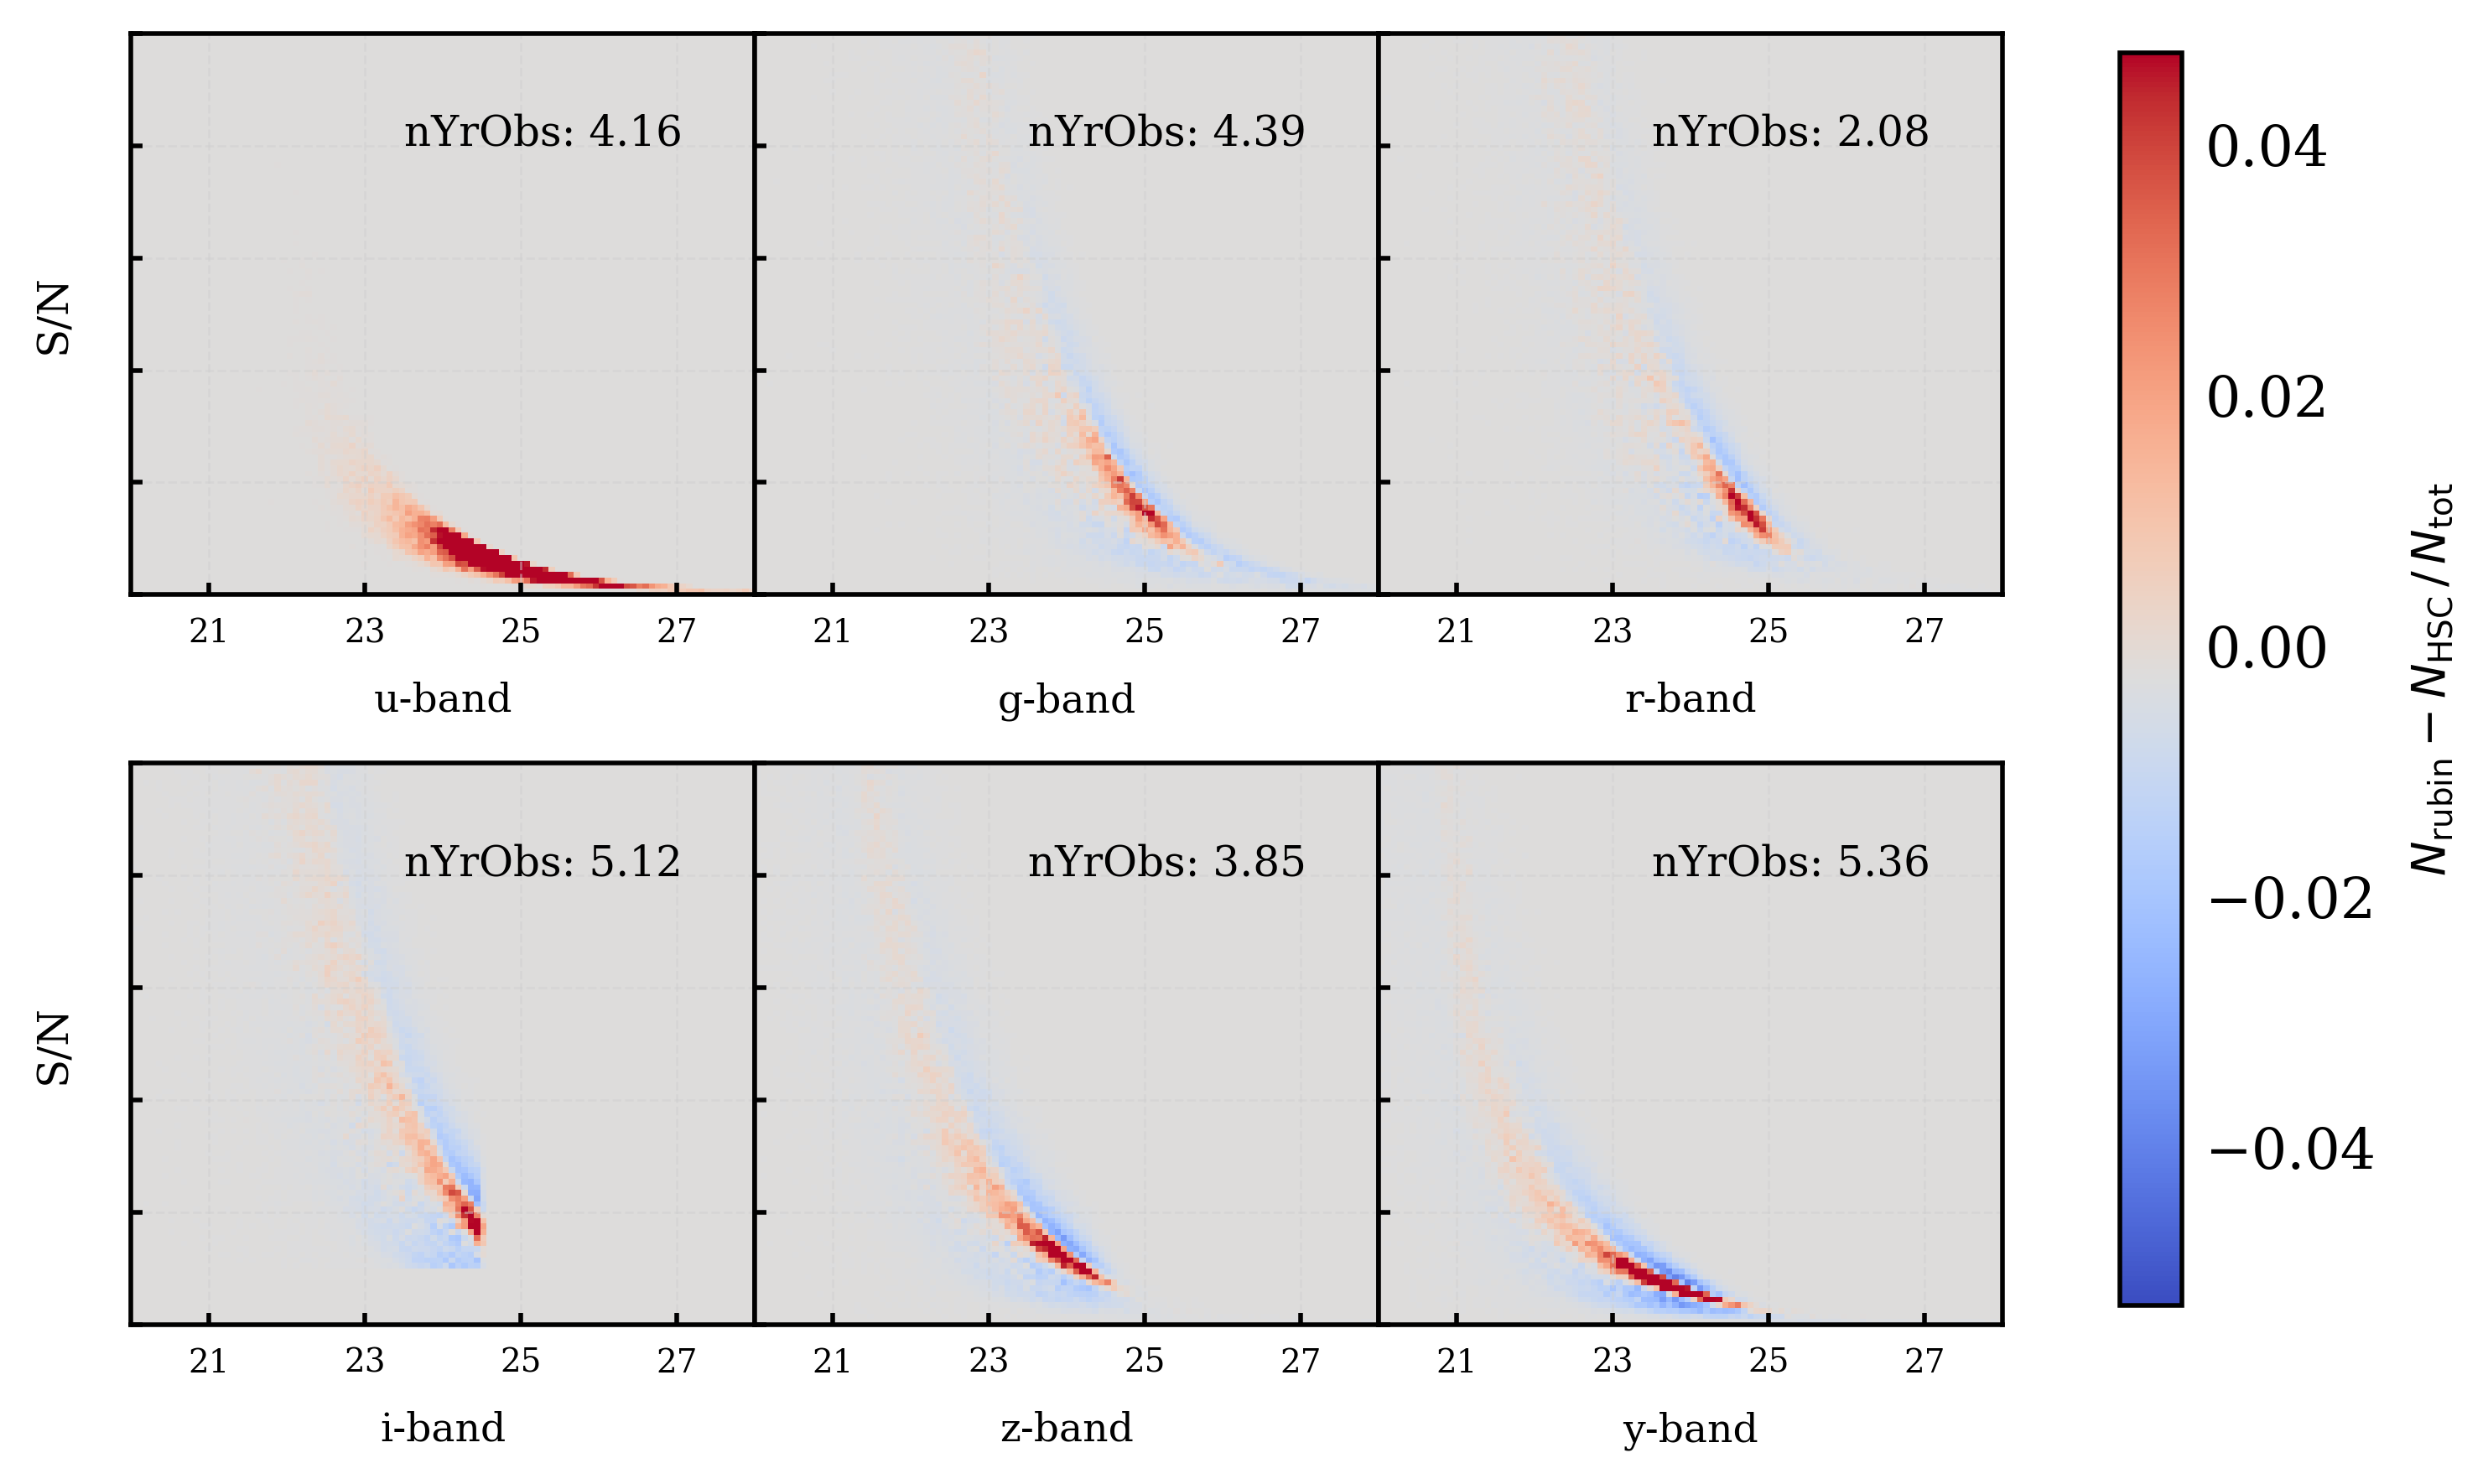

In [10]:
years = [np.round(np.mean(nyrobs_list),2)] + [np.round(results[band]['nYrObs'],2) for band in 'grizy']

plot_diff_errors(rubin_test, hsc, years=years)

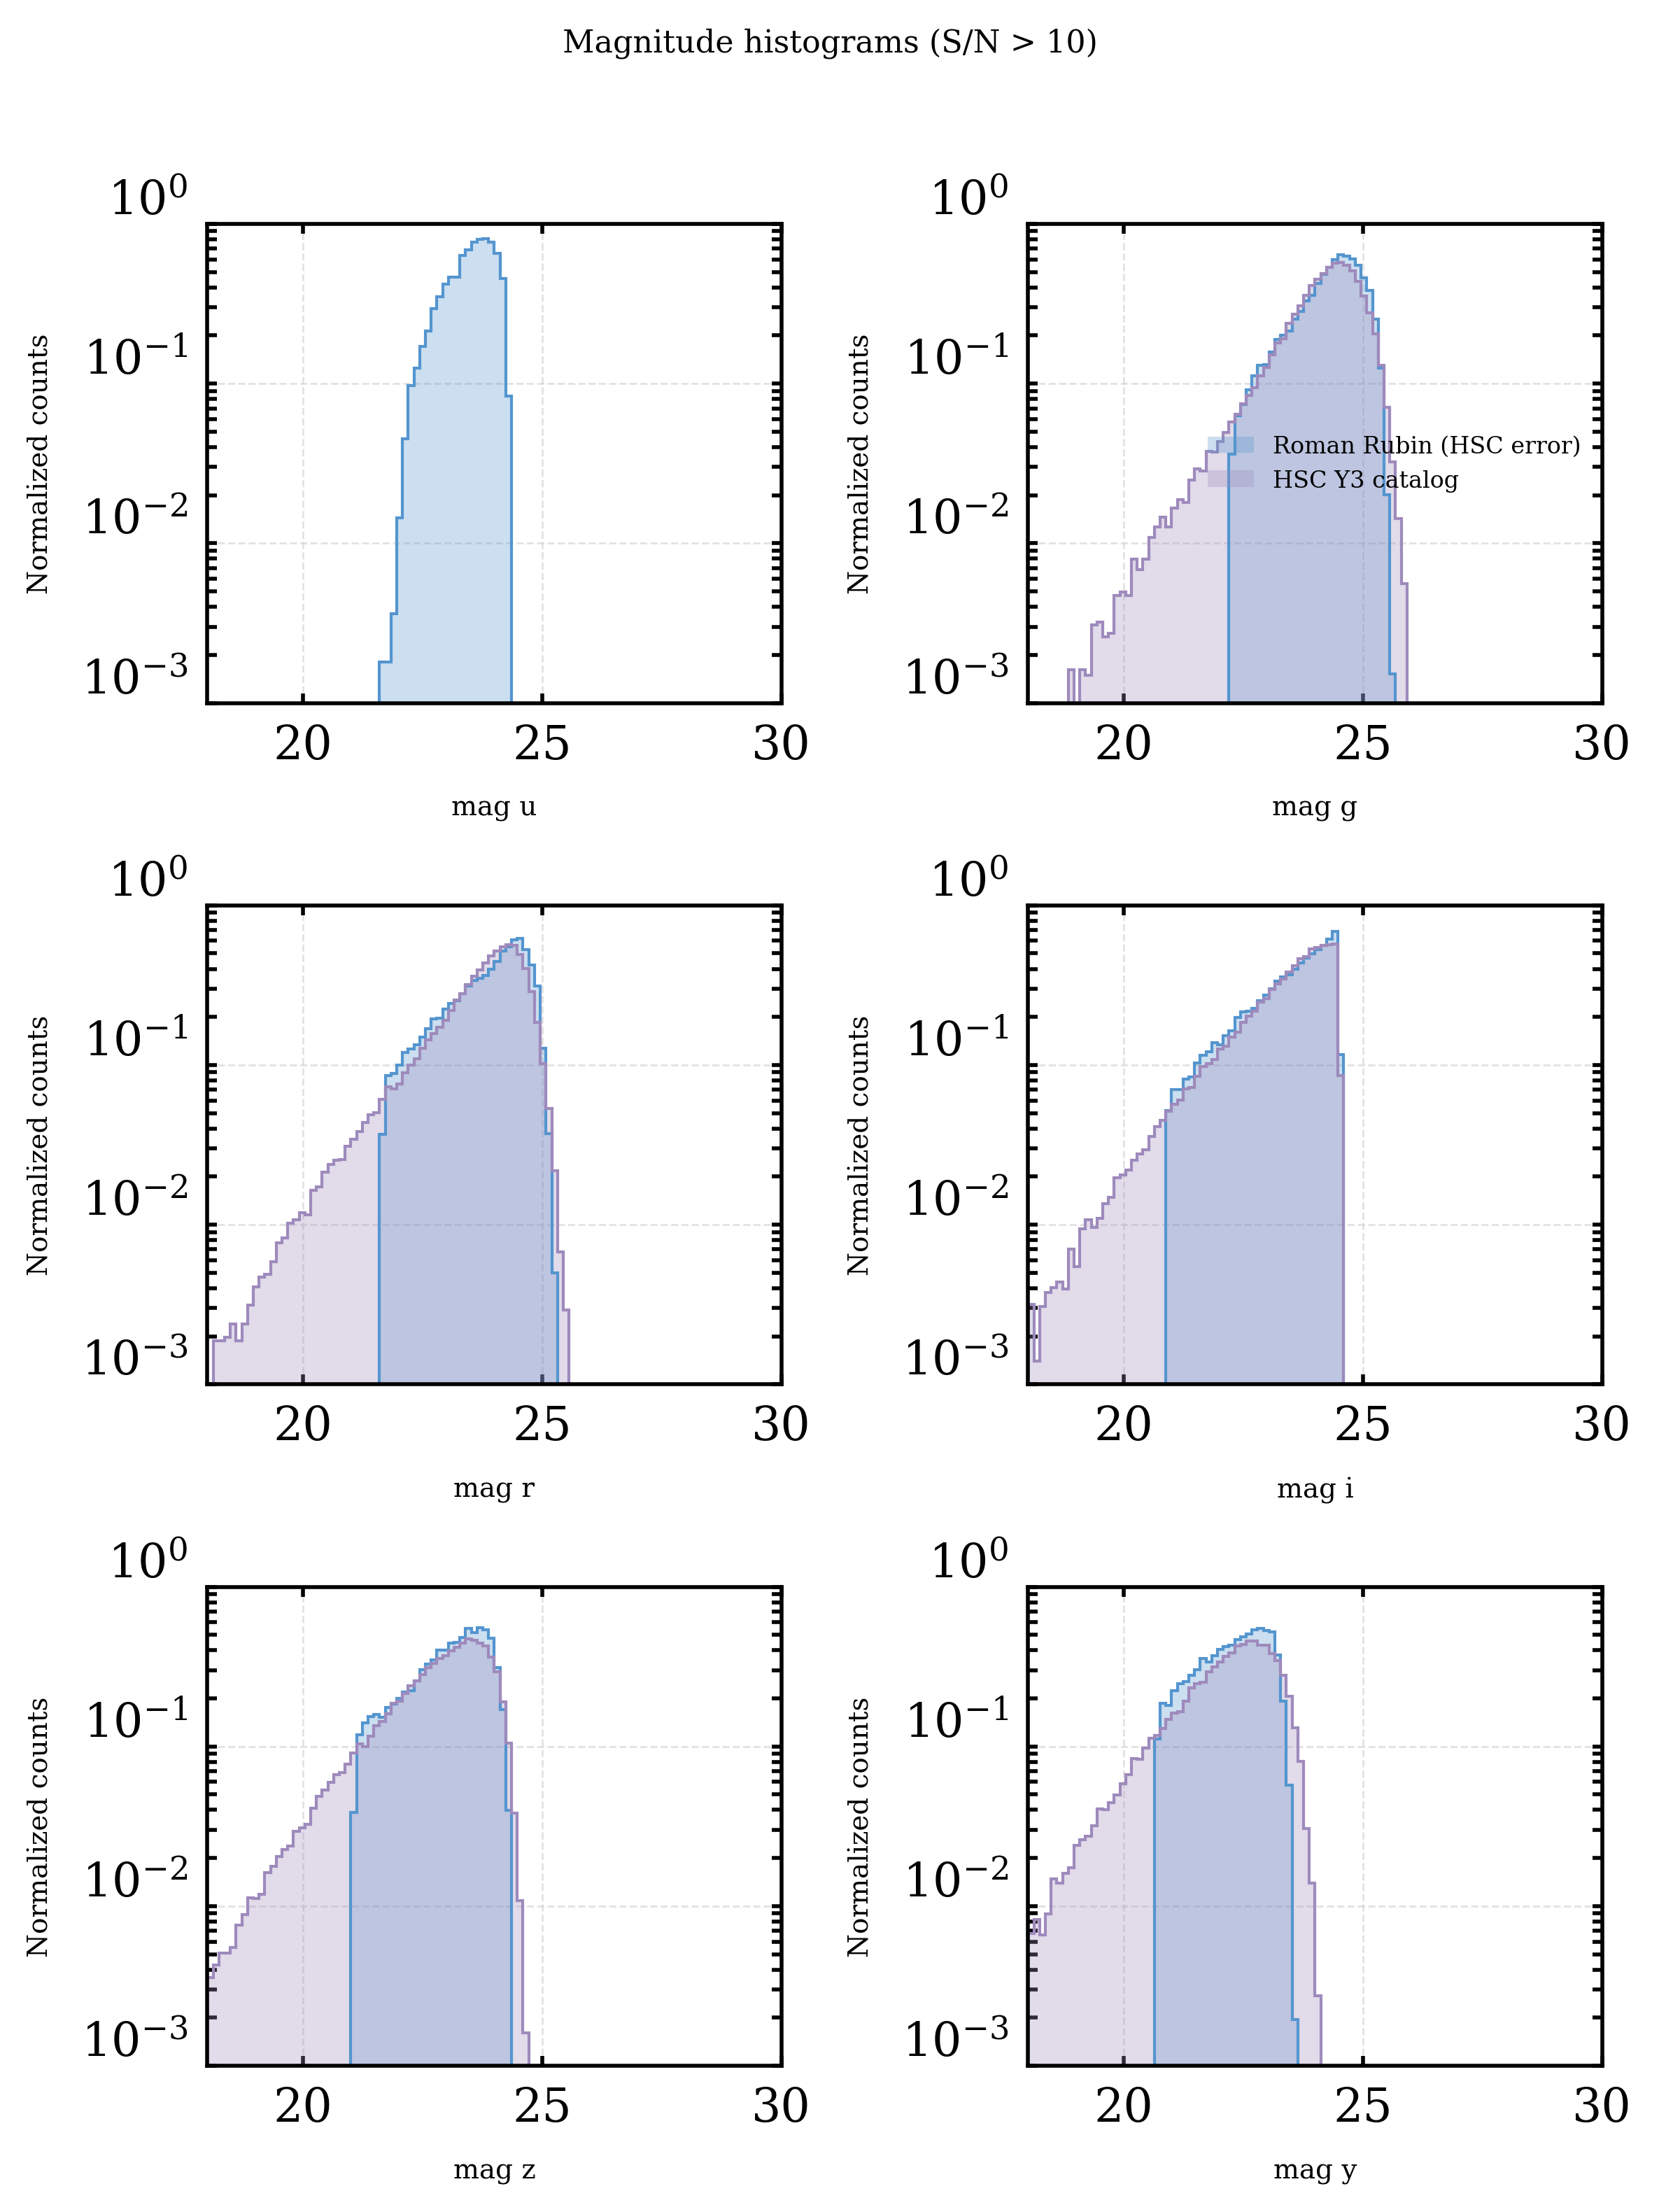

In [11]:
plot_mag_hist_comparison(rubin_test, hsc)

This plot above shows a problem:

In [12]:
for band in 'ugrizy':
    print(min(rubin_test[f'mag_{band}_lsst']))

21.39173589111148
22.213786714637777
21.650673491969144
20.892849027638213
21.074892439573283
20.672041326113085


This is caused by the gamma parameter that controls the shape of the tail of our distribution. So if its value is too different, we may end up having no objects at low magnitude, which can be a problem.

# Chi squared 2st try

Since we had a problem with gamma, we will only optimize nYrObs parameter here

## Tunning error model

In [13]:
def compute_counts(cat, mag_col, err_col, gridsize, maglim, snlim):
    """Builds a 2D histogram of object counts."""
    mag = cat[mag_col].values
    err_values = cat[err_col].values
    
    sn  = 1.086 / err_values
    mask = (mag > maglim[0]) & (mag < maglim[1]) & (sn > snlim[0]) & (sn < snlim[1])
    counts, _, _ = np.histogram2d(
        mag[mask], sn[mask], bins=gridsize, range=[maglim, snlim]
    )
    return counts

def loss_chi2_sym(N_1, N_2, eps=1.0):
    """Calculates the symmetric chi-squared."""
    return np.nansum((N_1 - N_2)**2 / (N_1 + N_2 + eps))

def add_error(rubin, band, nYrObs):
    # Define LSST filter names and mag column names
    mag_cols = [f"mag_{filt}_lsst" for filt in 'ugrizy']
    renameDict_mag = dict(zip('ugrizy', mag_cols))

    errModel = LsstErrorModel(
        extendedType="auto",
        ndFlag=99,
        nYrObs=nYrObs,
        renameDict=renameDict_mag
    )
    
    rubin_err = errModel(rubin, random_state=42)
    mag = rubin_err[f'mag_{band}_lsst']
    mag_err = rubin_err[f'mag_{band}_lsst_err']
    return mag, mag_err

def objective(params, cat, N_hsc, band, gridsize, maglim, snlim):
    nYrObs = float(params[0])
    
    mag, mag_err = add_error(cat, band, nYrObs)
    cat_tmp = cat.copy()
    cat_tmp[f"mag_{band}_lsst"] = mag
    cat_tmp[f"mag_{band}_lsst_err"] = mag_err
    
    N_rubin = compute_counts(
        cat_tmp,
        mag_col=f"mag_{band}_lsst",
        err_col=f"mag_{band}_lsst_err",
        gridsize=gridsize,
        maglim=maglim,
        snlim=snlim
    )
    return loss_chi2_sym(N_rubin, N_hsc)

40it [00:06,  6.20it/s]


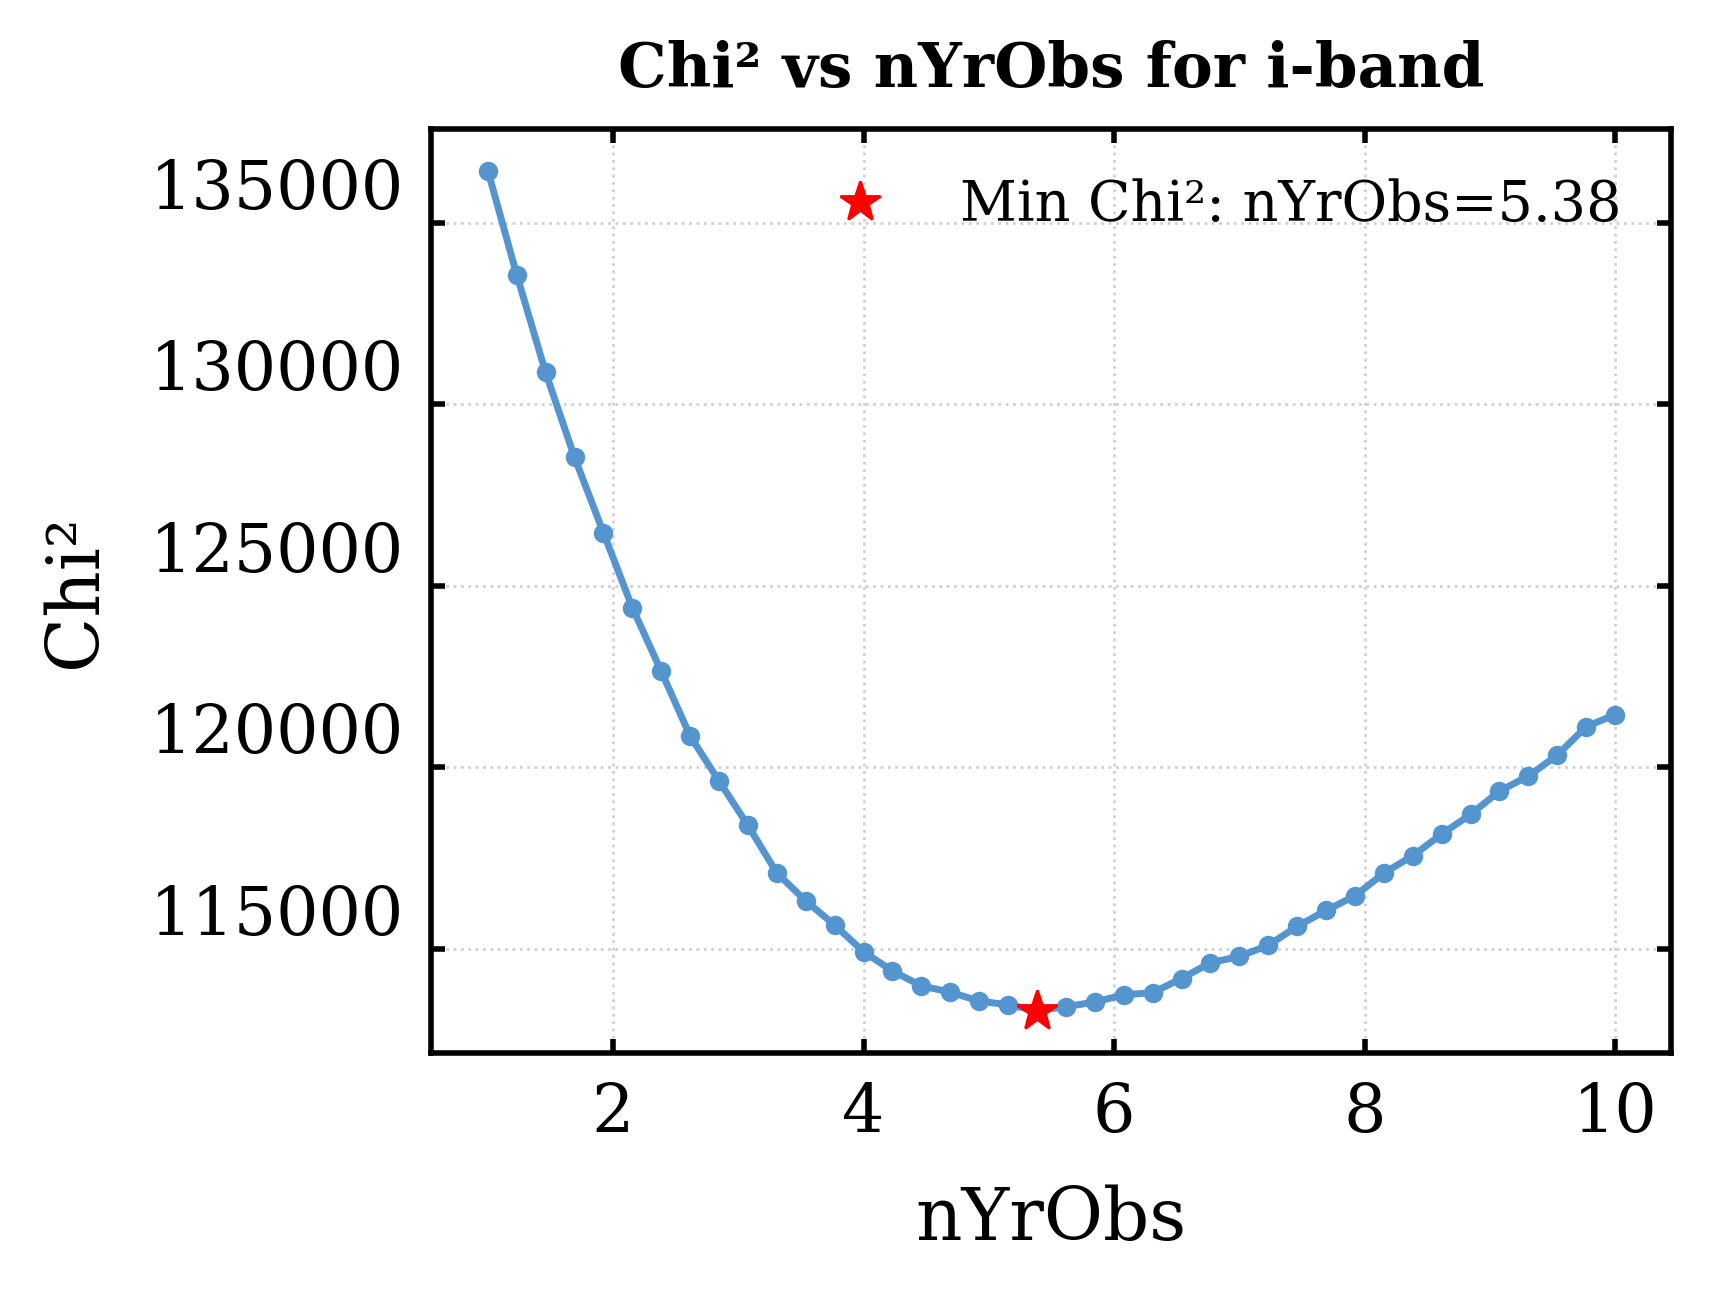

In [14]:
########## Base parameters ##########
x0 = [5] # initial guess nYrObs
bounds = [(1, 10)] # nYrObs
gridsize = 400
maglim = [18,30]
snlim = [0,100]

band_to_test = 'i'
#####################################

nyrobs_vals = np.linspace(1, 10, 40)
chi2_grid = np.zeros(len(nyrobs_vals))

# HSC counts
Nh = compute_counts(
    hsc,
    f"mag_{band_to_test}_lsst",
    f"mag_err_{band_to_test}_lsst",
    gridsize,
    maglim,
    snlim
)

for i, nyrobs in tqdm(enumerate(nyrobs_vals)):
    params = [nyrobs]
    chi2_grid[i] = objective(params, rubin, Nh, band_to_test, gridsize, maglim, snlim)

plt.figure(figsize=(8,6))
plt.plot(nyrobs_vals, chi2_grid, '-o')
plt.xlabel('nYrObs')
plt.ylabel('Chi²')
plt.title(f'Chi² vs nYrObs for {band_to_test}-band')
plt.grid(True)

best_idx = np.argmin(chi2_grid)
best_nyrobs = nyrobs_vals[best_idx]
plt.plot(best_nyrobs, chi2_grid[best_idx], 'r*', markersize=15,
         label=f'Min Chi²: nYrObs={best_nyrobs:.2f}')
plt.legend()
plt.show()

In [15]:
########## Base parameters ##########
x0 = [5] # initial guess nYrObs
bounds = [(1, 10)] # nYrObs
gridsize = 400
maglim = [18,30]
snlim = [0,100]
#####################################
results = {}

for band in 'grizy':
    N_hsc = compute_counts(hsc, f'mag_{band}_lsst', f'mag_err_{band}_lsst', gridsize, maglim, snlim)
    
    res = minimize(
        objective,
        x0,
        args=(rubin, N_hsc, band, gridsize, maglim, snlim),
        bounds=bounds,
        method='Nelder-Mead'
    )

    results[band] = {'nYrObs': res.x[0]}
    print(f"#### Band {band} ####")
    print("Best nYrObs:", res.x[0])
    print("Chi²:", res.fun)
print("Degrees of freedom:",len(rubin)-2)

#### Band g ####
Best nYrObs: 4.351380348205566
Chi²: 74834.27442152466
#### Band r ####
Best nYrObs: 2.1176910400390625
Chi²: 93985.60779078095
#### Band i ####
Best nYrObs: 5.064939498901367
Chi²: 113243.47563272643
#### Band z ####
Best nYrObs: 3.7804946899414062
Chi²: 99730.25222721553
#### Band y ####
Best nYrObs: 3.9965896606445312
Chi²: 92125.0771613041
Degrees of freedom: 99998


## Applying ErrorModel on Roman Rubin

In [16]:
rubin_test = pd.read_csv('test_roman_rubin_random_100k_265.csv', sep=' ')

In [17]:
nyrobs_list = []

all_mag = {}
all_magerr = {}
for band in 'grizy':
    temp_rubin = rubin_test.copy()
    
    nyrobs_list.append(results[band]['nYrObs'])
    
    mag, magerr = add_error(temp_rubin, band, results[band]['nYrObs'])
    all_mag[band] = mag
    all_magerr[band] = magerr

u_mag, u_magerr = add_error(rubin_test, 'u', np.mean(nyrobs_list))
all_mag['u'] = u_mag
all_magerr['u'] = u_magerr

In [18]:
for band in 'ugrizy':
    rubin_test[f'mag_{band}_lsst'] = all_mag[band]
    rubin_test[f'mag_err_{band}_lsst'] = all_magerr[band]

In [19]:
for band in 'grizy':
    N_rubin = compute_counts(rubin_test, f'mag_{band}_lsst', f'mag_err_{band}_lsst', 400, [18,30], [0,100])
    N_hsc = compute_counts(hsc, f'mag_{band}_lsst', f'mag_err_{band}_lsst', 400, [18,30], [0,100])
    loss = loss_chi2_sym(N_rubin, N_hsc, eps=1.0)
    print(f'Chi2 for test sample ({band}-band):', loss)

Chi2 for test sample (g-band): 75439.30514554202
Chi2 for test sample (r-band): 94776.68016131398
Chi2 for test sample (i-band): 113827.85395410721
Chi2 for test sample (z-band): 100337.87478377171
Chi2 for test sample (y-band): 92691.41480267874


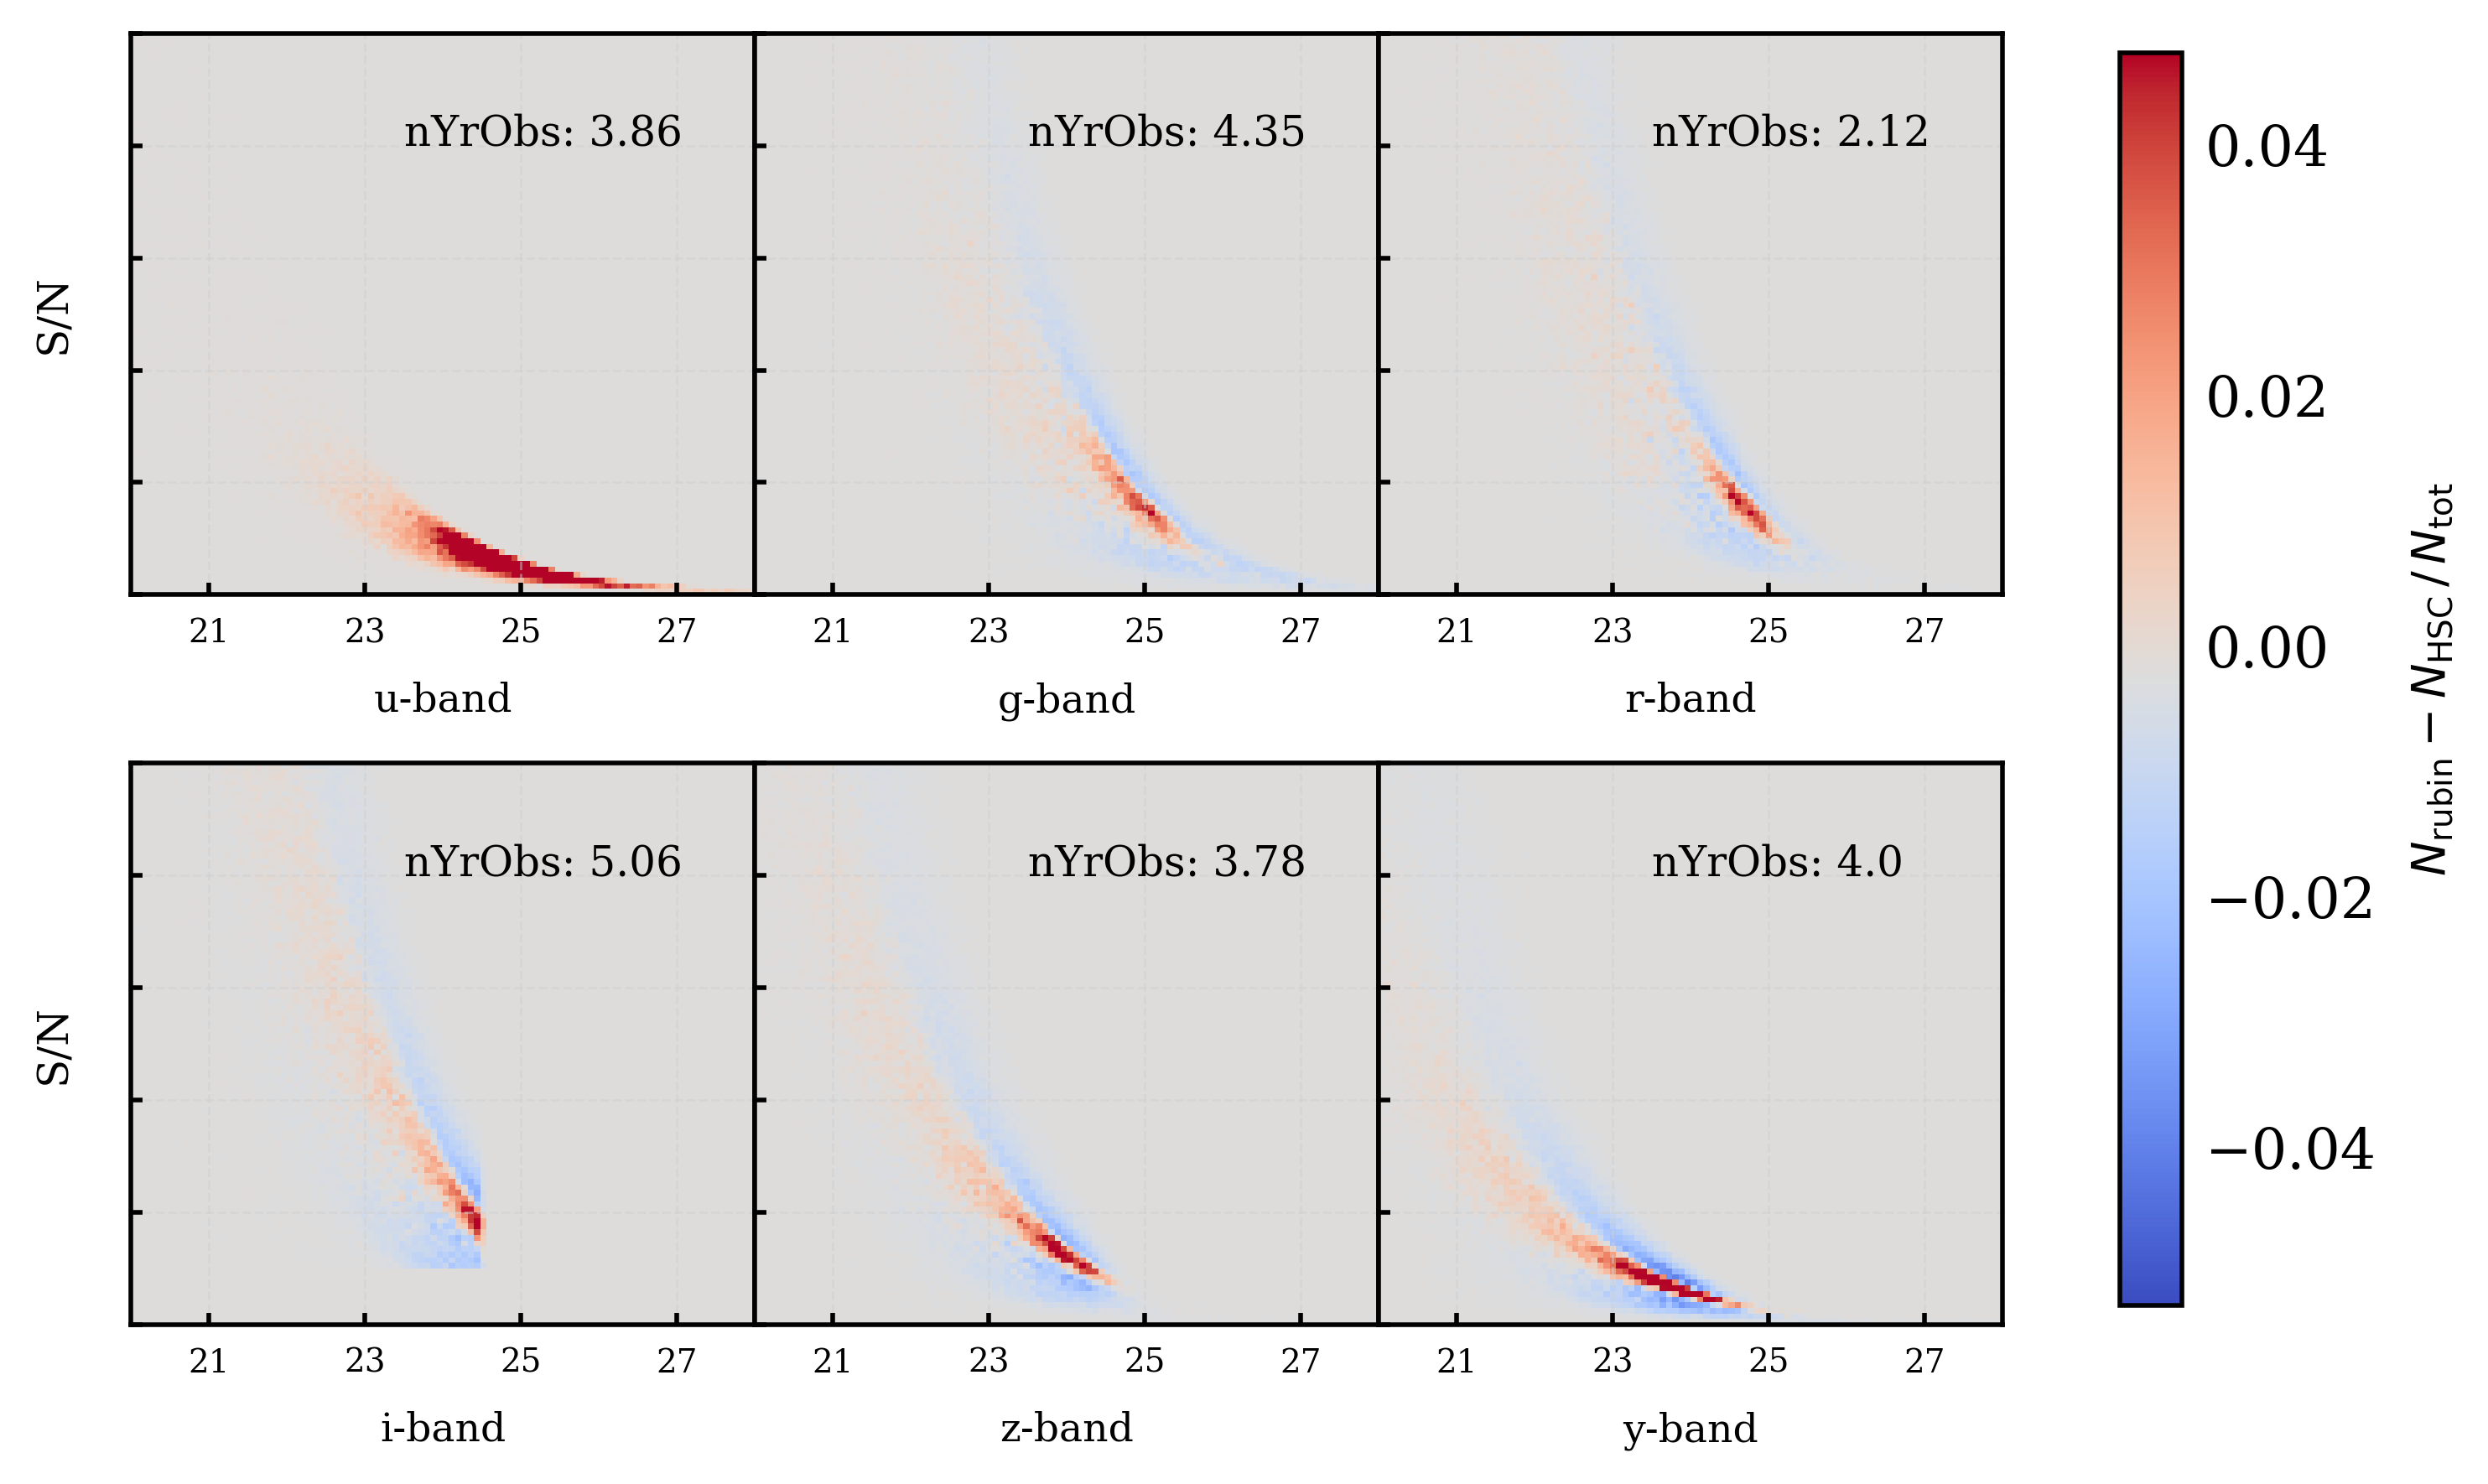

In [20]:
years = [np.round(np.mean(nyrobs_list),2)] + [np.round(results[band]['nYrObs'],2) for band in 'grizy']

plot_diff_errors(rubin_test, hsc, years=years)

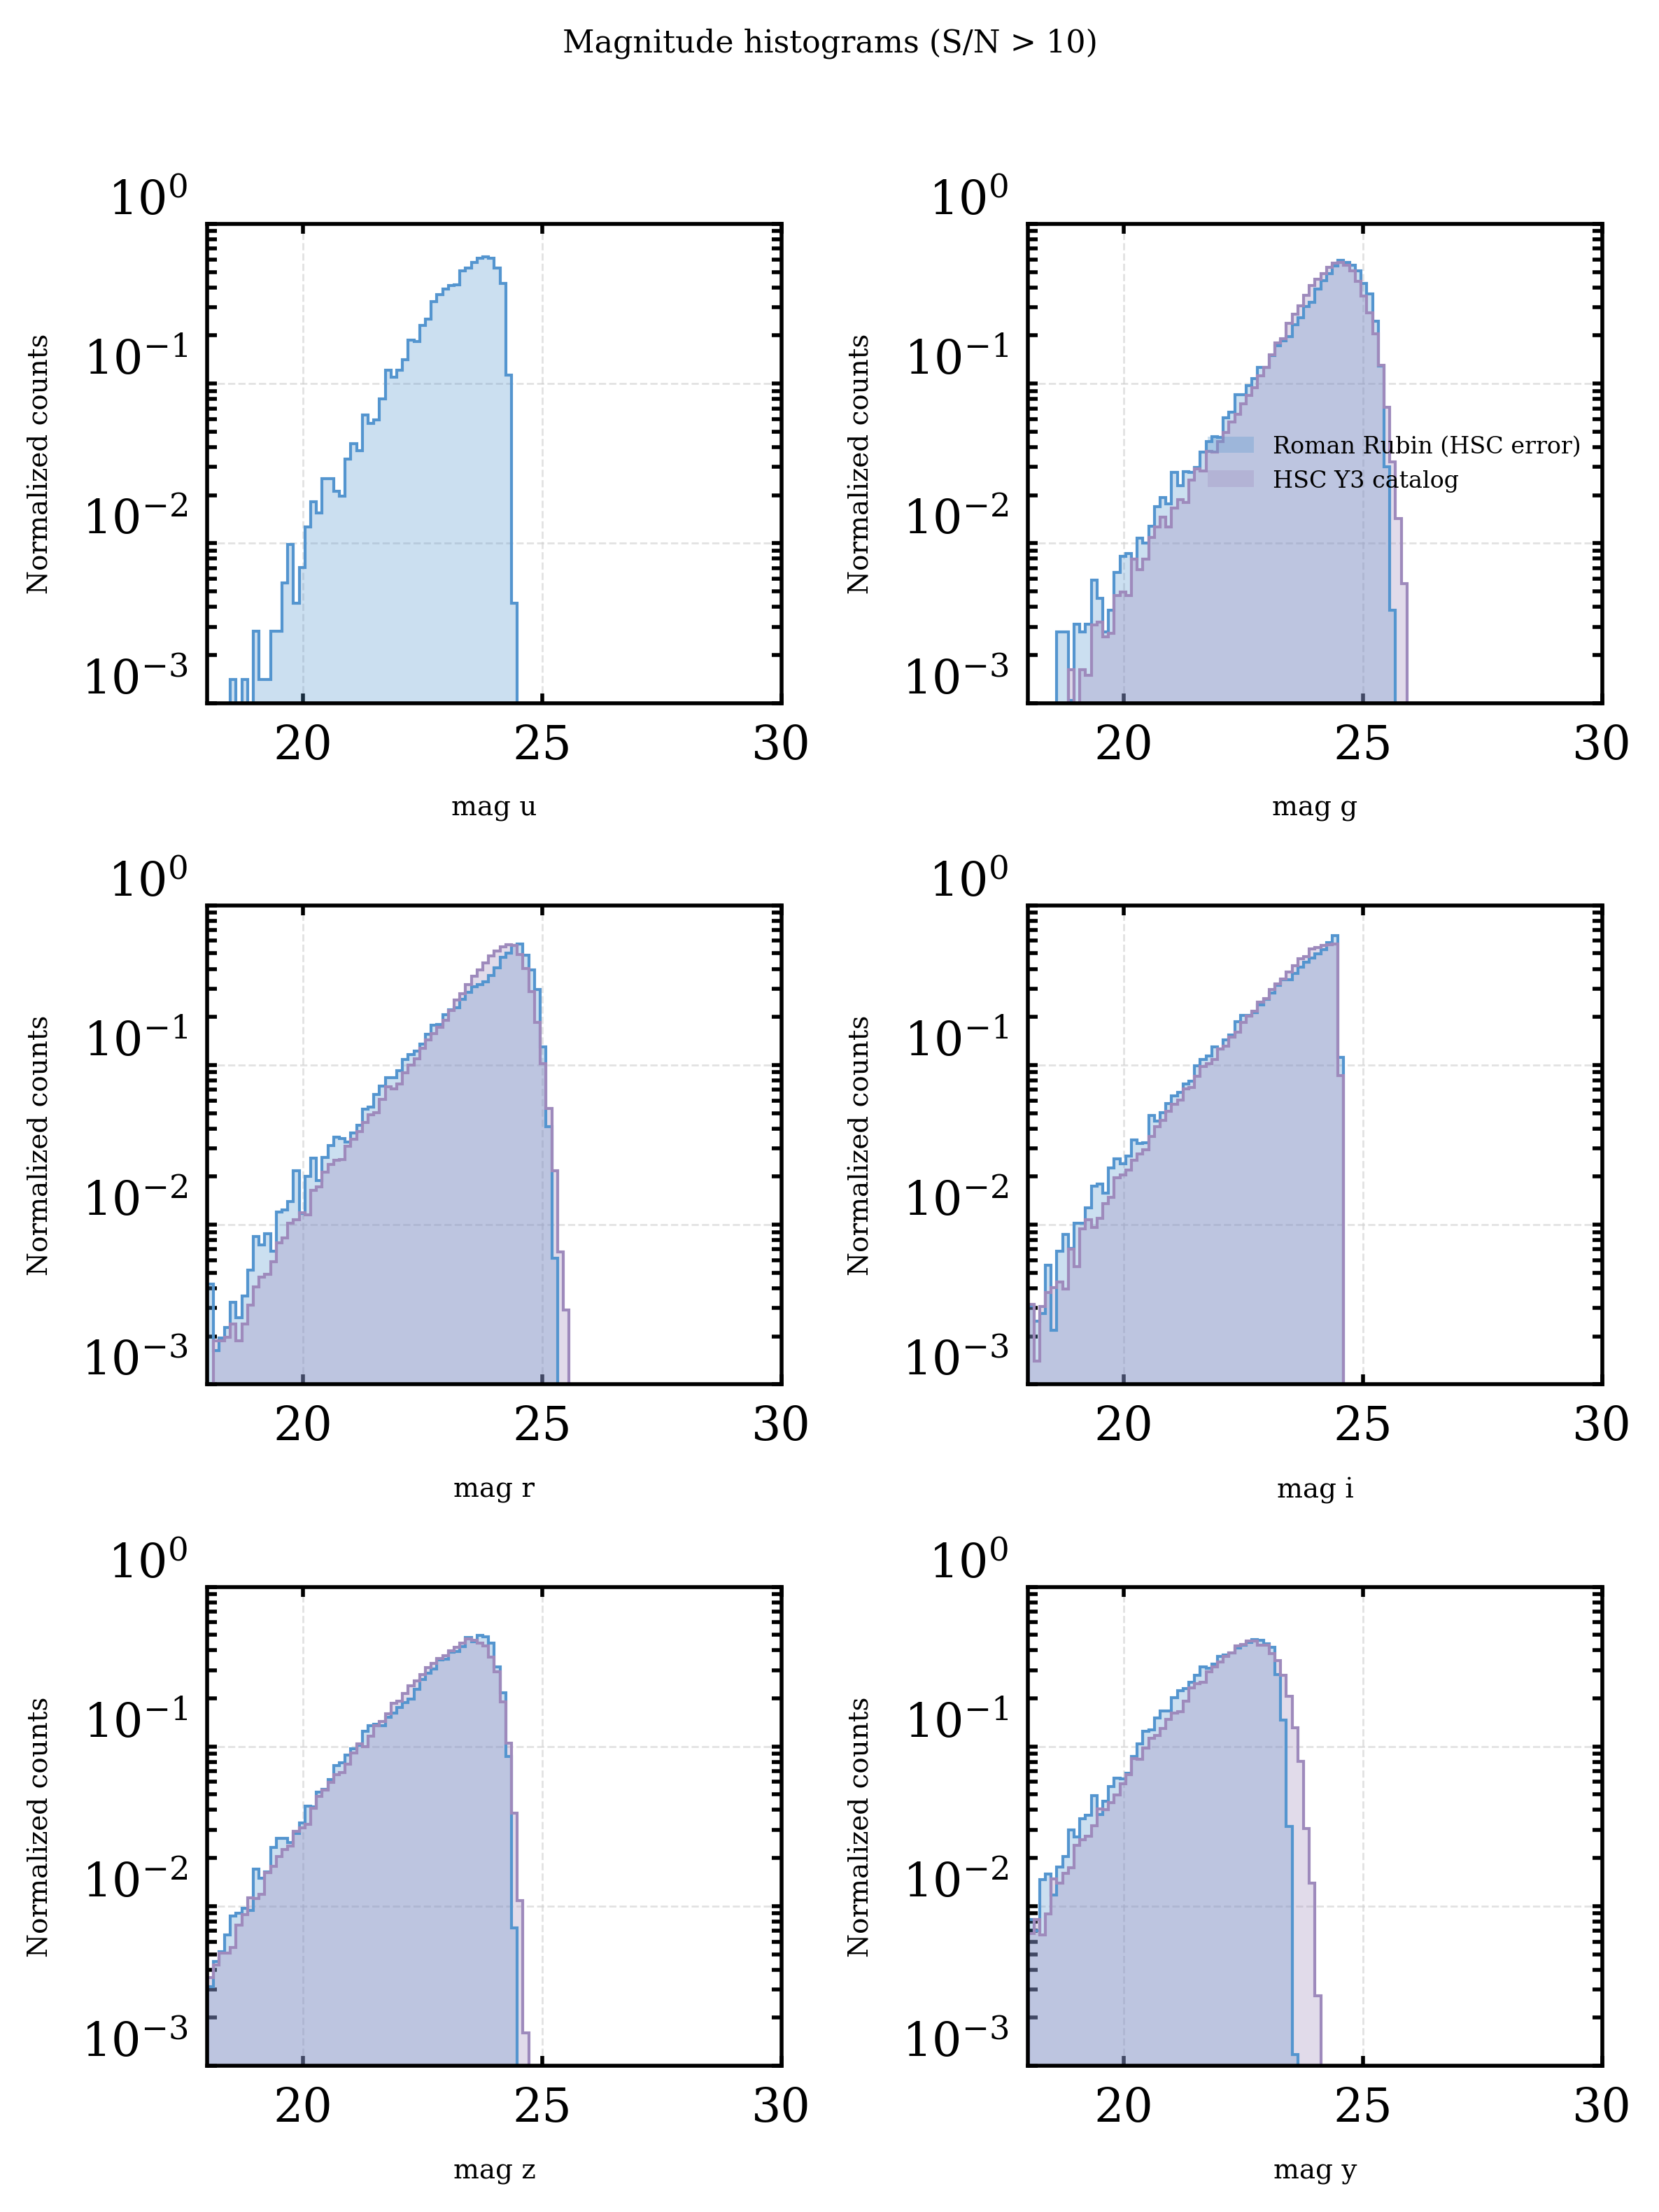

In [21]:
plot_mag_hist_comparison(rubin_test, hsc)